In [ ]:
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:

!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt install poppler-utils -y
!pip install langchain unstructured[all-docs] pydantic lxml openai faiss-cpu
!pip install langchain-community
!pip install nltk unstructured[pdf]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [ ]:
from google.colab import userdata



In [ ]:
#output_path ="./images"

In [ ]:
openai_api_key = userdata.get('open_ai')

# Filepaths for both PDFs
pdf_1_path = "/content/psoriasis doc.pdf"
pdf_2_path = "/content/Healthcare-Professionals-Guide-June-2018.pdf"

# Output directory for images
output_path = "/content/extracted_images"

# Partition PDF 1 (text and images)
raw_pdf_elements_pdf_1 = partition_pdf(
    filename=pdf_1_path,
    extract_images_in_pdf=True,               # Extract images
    infer_table_structure=True,               # Infer table structures
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path  # Output directory for images
)

# Partition PDF 2 (only text)
raw_pdf_elements_pdf_2 = partition_pdf(
    filename=pdf_2_path,
    extract_images_in_pdf=False,              # Skip image extraction
    infer_table_structure=True,               # Optionally infer table structures
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000
)

# Process the extracted elements as needed for both PDFs
# For example, you can now extract the text or other elements from the PDFs and handle them accordingly.


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Combine elements from both PDFs
raw_pdf_elements = raw_pdf_elements_pdf_1 + raw_pdf_elements_pdf_2

# Initialize lists to hold text and table elements
text_elements = []
table_elements = []

# Initialize lists for summaries
text_summaries = []
table_summaries = []

# Define a summary prompt
summary_prompt = """
Summarize the following {element_type}:
{element}
"""


In [ ]:
# Importing LangChain components
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

# Create a summary chain using LangChain
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)  # Fixed missing parenthesis
)

<ipython-input-9-a9ed280e974b>:8: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key, max_tokens=1024),
<ipython-input-9-a9ed280e974b>:7: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summary_chain = LLMChain(


In [ ]:
for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):  # Check if it's a CompositeElement (text)
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e.text})  # Pass e.text for summarization
        text_summaries.append(summary)
    elif 'Table' in repr(e):  # Check if it's a Table element
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e.text})  # Pass e.text for summarization
        table_summaries.append(summary)

# Now you have text_summaries and table_summaries for both PDFs

<ipython-input-10-64a231cfecc7>:4: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summary_chain.run({'element_type': 'text', 'element': e.text})  # Pass e.text for summarization


In [ ]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [ ]:
!pip install faiss-cpu
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.7 MB/s eta 0:00:00


In [ ]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

<ipython-input-13-6e6320996726>:42: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))


In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key = openai_api_key)


In [ ]:
vectorstore.save_local("faiss_index")

In [ ]:
prompt_template = """
You are an expert in skin diseases, especially eczema and related conditions.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
If you are unsure or do not have enough information, decline to answer by saying "Sorry, I don't have enough information about it."
Please provide a detailed and helpful response if possible.
Answer:
"""


In [ ]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-4o", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [ ]:
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [ ]:
result, relevant_images = answer("what is psoriasis skin disease?")
result

"Psoriasis is a common chronic, recurrent, immune-mediated disease that primarily affects the skin and joints. It significantly impacts the physical, emotional, and psychosocial well-being of those affected. The disease is characterized by the presence of scaling papules and plaques, which are raised lesions of varying size, often with a grey or silvery-white dry scale. These lesions are typically well-circumscribed, red, and symmetrically distributed on common areas such as the scalp, elbows, knees, lumbosacral region, and body folds.\n\nPsoriasis is a papulosquamous disorder, which means it involves both papules (small, raised lesions) and scales. The condition is notable for its variability in morphology, distribution, severity, and course. For instance, psoriasis can range from small tear-shaped lesions (guttate psoriasis) to more severe forms like pustular or erythrodermic psoriasis. Additionally, psoriasis can be stable with chronic plaques or rapidly progressive with widespread 

In [ ]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHeAnwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDFXc+1seg/GlBL4LDPanea2w7VwnXNCM0f7zbnDV2HlgWxGAo6dad5okijXbhkPJ9aTO6UEDBOc04tGYkUDDqeTQAbwu5dvU5prBXcntipCyuY8DAPWkEaZHPc0mAyTZkKOm3n605zGGCqT0olRRIQnQ4po278ntSANqAgHr

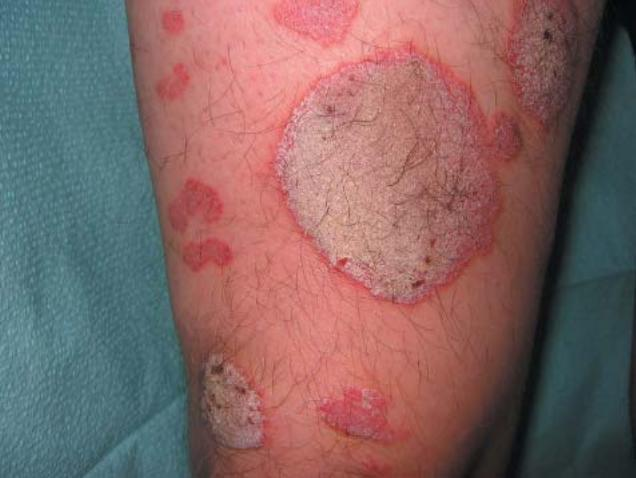

In [ ]:
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))